In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import nltk
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer


**Loading Dataset**

In [20]:
df = pd.read_csv('spam.csv', encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


**Delete Columns**

In [21]:
new_df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
new_df.head()


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Assigning Labels**

In [22]:
y = df["v1"]

In [23]:
x = df["v2"]

**Checking Missing Values**

In [24]:
new_df.isnull().sum()

v1    0
v2    0
dtype: int64

<Axes: >

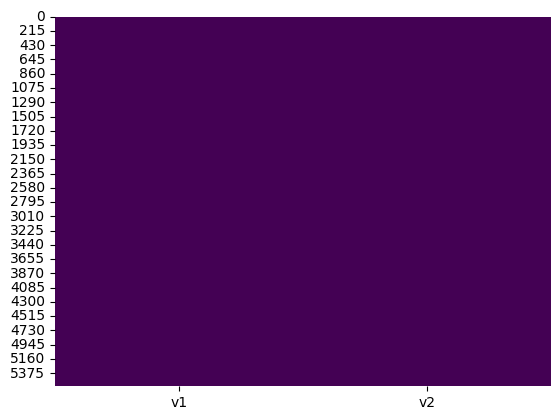

In [25]:
sb.heatmap(new_df.isnull(),cbar=False,cmap='viridis')

**Data Cleaning**

In [ ]:
def Data_Clean():
  print("Processing...")

  # replacing na values in college with No college
  df["v2"].fillna("No Statement.", inplace = True)

Data_Clean()
print("Cleaning over..")

In [ ]:
new_df.head()

In [ ]:
y.head()

In [ ]:
x.head()

**Convert Messages to Lower case**

In [ ]:
x_new = [text.lower() for text in x]
x = x_new
x

**Removing Stop Words**

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stopwords = set(stopwords.words('english'))

filtered_sentence = []
for w in x:
    if w not in stopwords:
        filtered_sentence.append(w)

x_new = filtered_sentence
x = x_new
x

**Performing Tokenization**

In [ ]:
nltk.download('punkt')
x_new = [word_tokenize(da) for da in x ]
x = x_new
x


**Used PorterStemmer**

In [35]:
from nltk.stem import PorterStemmer

# Create an instance of the PorterStemmer
stemmer = PorterStemmer()

x_new =[ ]
data = []
for tokens in x:
  words = [stemmer.stem(token) for token in tokens]
  data.append(words)

# Now, 'new_df['v2']' will contain the stemmed versions of the words in the 'v2' column.


In [ ]:
data[0]

**Word2Vec Embedding**

In [37]:
from gensim.models import Word2Vec

from nltk.tokenize import word_tokenize

x_sentences = [' '.join(sentence) for sentence in data]
# Tokenize the data
tokenized_data = [word_tokenize(sentence) for sentence in x_sentences]
# Train Word2Vec
model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, workers=4)

In [38]:
# Convert tokenized data into Word2Vec vectors

word2vec_vectors = []

for sentence in tokenized_data:

    vectors = [model.wv[word] for word in sentence if word in model.wv]

    word2vec_vectors.append(vectors)

print(f"Shape of the Word2Vec is : {np.shape(word2vec_vectors)}")

averaged_word2vec_vectors = []

for index in range(len(word2vec_vectors)):

    vectors = word2vec_vectors[index]

    if vectors:

      averaged_vector = np.mean(vectors, axis=0)  # Calculate the mean along axis=0

      averaged_word2vec_vectors.append(averaged_vector)

    else:

      print(f"Index : {index}")

Shape of the Word2Vec is : (5572,)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


**Applying Train-Test Split**

In [52]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming you already have 'word2vec_embeddings' and 'labels'

# Convert averaged_word2vec_vectors to numpy array
word2vec_embeddings = np.array(averaged_word2vec_vectors)

# Convert labels to numpy array
labels = np.array(y)

# Perform train-test split (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(word2vec_embeddings, labels, test_size=0.2, random_state=42)

# Print the shapes of train and test sets to verify
print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (4457, 100)
y_train shape: (4457,)
X_test shape: (1115, 100)
y_test shape: (1115,)


**Applying Models**

**RNN**

In [ ]:
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.metrics import accuracy_score

# Reshape the data to include a time step dimension for RNN
x_train_rnn = np.expand_dims(x_train, axis=1)
x_test_rnn = np.expand_dims(x_test, axis=1)

# Define the RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(64, input_shape=(1, word2vec_embeddings.shape[1]), activation='relu'))
model_rnn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert string labels to numerical values (0 for 'ham', 1 for 'spam')
y_train[y_train == 'ham'] = 0
y_train[y_train == 'spam'] = 1

# Ensure y_train is in integer format
y_train = y_train.astype(int)

# Train the model
history_rnn = model_rnn.fit(x_train_rnn, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Predict probabilities for RNN
y_pred_prob_rnn = model_rnn.predict(x_test_rnn)
y_pred_rnn = (y_pred_prob_rnn > 0.5).astype(int).flatten()

# Convert string labels in y_test to numerical values (0 for 'ham', 1 for 'spam')
y_test[y_test == 'ham'] = 0
y_test[y_test == 'spam'] = 1

# Ensure y_test is in integer format
y_test = y_test.astype(int)




In [54]:
# Calculate accuracy for RNN
accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
print("RNN Model Accuracy Is:", accuracy_rnn)

RNN Model Accuracy Is: 0.9596412556053812


**LSTM Model**

In [ ]:
# Reshape the data to include a time step dimension for RNN
x_train_lstm = np.expand_dims(x_train, axis=1)
x_test_lstm = np.expand_dims(x_test, axis=1)

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(1, word2vec_embeddings.shape[1]), activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
lstm = model_lstm.fit(x_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.1)

In [56]:
# Predict probabilities for LSTM
y_pred_prob_lstm = model_lstm.predict(x_test_lstm)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int).flatten()

# Calculate accuracy for LSTM
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
print("LSTM Accuracy:", accuracy_lstm)

35/35 [==============================] - 1s 5ms/step
LSTM Accuracy: 0.957847533632287
